In [1]:
from keras.models import Model
from keras.layers import Add, concatenate, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, TimeDistributed, LSTM
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
import numpy as np
import os
import cv2
from keras.applications.mobilenet import MobileNet
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.losses import mean_squared_error

from preprocessing import BatchGenerator
from preprocessing_seq import BatchGeneratorVideo
from backend import TinyYoloFeature, FullYoloFeature, MobileNetFeature, SqueezeNetFeature, Inception3Feature, VGG16Feature, ResNet50Feature
from utils import decode_netout, compute_overlap, compute_ap, draw_boxes

from keras import backend as K
K.set_learning_phase(1) 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import argparse
import os
import numpy as np
from preprocessing import parse_annotation
import json

from lstm import TT_LSTM

In [3]:
class YOLO(object):
    def __init__(self, backend,
                       input_size, 
                       labels, 
                       max_box_per_image,
                       anchors,
                       tt_input_shape = None,
                       pretrained_weights=None):
        
        self.sequence_length = 8
        self.batch_size = 2

        self.curves = dict()
        self.curves['consistency'] = []
        self.curves['yolo'] = []
        self.curves['all'] = []

        yolo_detection_model = self.get_yolo_model(backend,
                       input_size, 
                       labels, 
                       max_box_per_image,
                       anchors,
                       pretrained_weights)
        
        yolo_detection_model.trainable = False
        
        input_image     = Input(shape=(None, self.input_size, self.input_size, 3))
        self.true_boxes = Input(shape=(None, 1, 1, 1, max_box_per_image , 4))
        
        
        flatten_size = self.grid_h * self.grid_w * self.nb_box * (4 + 1 + self.nb_class)
        
        y_detection = TimeDistributed(yolo_detection_model)(input_image)
        detection = TimeDistributed(Reshape((flatten_size, )))(y_detection)
        
        tt_output_shape = tt_input_shape
        print('flatten size', flatten_size)
        
        assert flatten_size == np.prod(tt_input_shape), "wrong tt input shape"
        
        detection = TT_LSTM(row_dims=tt_input_shape,
                            column_dims=tt_output_shape,
                            tt_rank=7,
                            return_sequences=True,
                            dropout=0.25, recurrent_dropout=0.25, activation='tanh')(detection)
        
        l_detection = TimeDistributed(Reshape((self.grid_h, self.grid_w, self.nb_box * (4 + 1 + self.nb_class))))(detection)
        
        res_maps = Add()([y_detection, l_detection])
        
#        final_conv_layer = Conv2D(self.nb_box * (4 + 1 + self.nb_class), 
#                        (1,1), strides=(1,1), 
#                        padding='same', 
#                        name='FinalDetectionLayer', 
#                        kernel_initializer='lecun_normal')
        
#        final_detection = TimeDistributed(final_conv_layer)(res_maps)

        # make the object detection layer
        output = TimeDistributed(Reshape((self.grid_h, self.grid_w, self.nb_box, 4 + 1 + self.nb_class)))(res_maps)
        output = Lambda(lambda args: args[0])([output, self.true_boxes])

        self.model = Model([input_image, self.true_boxes], output)

        # print a summary of the whole model
        self.model.summary()
        
    def get_yolo_model(self, backend,
                       input_size, 
                       labels, 
                       max_box_per_image,
                       anchors, weights_pretrained=None):
        self.input_size = input_size
        
        self.labels   = list(labels)
        self.nb_class = len(self.labels)
        self.nb_box   = len(anchors)//2
        self.class_wt = np.ones(self.nb_class, dtype='float32')
        self.anchors  = anchors

        self.max_box_per_image = max_box_per_image

        ##########################
        # Make the model
        ##########################

        # make the feature extractor layers
        input_image     = Input(shape=(self.input_size, self.input_size, 3))
        true_boxes      = Input(shape=(1, 1, 1, max_box_per_image , 4))

        if backend == 'Inception3':
            self.feature_extractor = Inception3Feature(self.input_size)  
        elif backend == 'SqueezeNet':
            self.feature_extractor = SqueezeNetFeature(self.input_size)        
        elif backend == 'MobileNet':
            self.feature_extractor = MobileNetFeature(self.input_size)
        elif backend == 'Full Yolo':
            self.feature_extractor = FullYoloFeature(self.input_size)
        elif backend == 'Tiny Yolo':
            self.feature_extractor = TinyYoloFeature(self.input_size)
        elif backend == 'VGG16':
            self.feature_extractor = VGG16Feature(self.input_size)
        elif backend == 'ResNet50':
            self.feature_extractor = ResNet50Feature(self.input_size)
        else:
            raise Exception('Architecture not supported! Only support Full Yolo, Tiny Yolo, MobileNet, SqueezeNet, VGG16, ResNet50, and Inception3 at the moment!')

        print(self.feature_extractor.get_output_shape())    
        self.grid_h, self.grid_w = self.feature_extractor.get_output_shape()        
        features = self.feature_extractor.extract(input_image)            

        # make the object detection layer
        detection_layer = Conv2D(self.nb_box * (4 + 1 + self.nb_class), 
                        (1,1), strides=(1,1), 
                        padding='same', 
                        name='DetectionLayer', 
                        kernel_initializer='lecun_normal')(features)
        output = Reshape((self.grid_h, self.grid_w, self.nb_box, 4 + 1 + self.nb_class))(detection_layer)
        output = Lambda(lambda args: args[0])([output, true_boxes])

        model = Model([input_image, true_boxes], output)
        if weights_pretrained:
            model.load_weights(weights_pretrained)
            
        detection_model = Model(input_image, detection_layer)
            
        return detection_model

    def consistency_loss(self, y_true, y_pred):
        loss = 0
        for i in range(self.sequence_length - 1):
            loss += K.mean(K.square(y_pred[:, i] - y_pred[:, i + 1]))
        loss /= self.sequence_length
        

        self.curves['consistency'].append(loss)
        
        return loss
    
    def yolo_loss(self, y_true, y_pred):
        loss = 0
        
        for i in range(self.sequence_length):
            loss += self.custom_loss(y_true[:, i], y_pred[:, i], self.true_boxes[:, i])
        loss /= self.sequence_length
        
        self.curves['yolo'].append(loss)
        
    
        
        return loss

    def custom_new_loss(self, y_true, y_pred):
        y_loss = self.yolo_loss(y_true, y_pred)
        c_loss = 1e-1 * self.consistency_loss(y_true, y_pred)
        
        loss = y_loss + c_loss
        
        self.curves['all'].append(loss)
        
        loss = tf.Print(loss, [c_loss], message='Consistency loss \t', summarize=1000)
        loss = tf.Print(loss, [y_loss], message='Mean overall loss \t', summarize=1000)
        loss = tf.Print(loss, [loss], message='Sequence loss \t', summarize=1000)
        
        return loss

    def custom_loss(self, y_true, y_pred, true_box):
        mask_shape = tf.shape(y_true)[:4]
        
        cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(self.grid_w), [self.grid_h]), (1, self.grid_h, self.grid_w, 1, 1)))
        cell_y = tf.transpose(cell_x, (0,2,1,3,4))

        cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [self.batch_size, 1, 1, self.nb_box, 1])
        
        coord_mask = tf.zeros(mask_shape)
        conf_mask  = tf.zeros(mask_shape)
        class_mask = tf.zeros(mask_shape)
        
        seen = tf.Variable(0.)
        total_recall = tf.Variable(0.)
        
        """
        Adjust prediction
        """
        ### adjust x and y      
        pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
        
        ### adjust w and h
        pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(self.anchors, [1,1,1,self.nb_box,2])
        
        ### adjust confidence
        pred_box_conf = tf.sigmoid(y_pred[..., 4])
        
        ### adjust class probabilities
        pred_box_class = y_pred[..., 5:]
        
        """
        Adjust ground truth
        """
        ### adjust x and y
        true_box_xy = y_true[..., 0:2] # relative position to the containing cell
        
        ### adjust w and h
        true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
        
        ### adjust confidence
        true_wh_half = true_box_wh / 2.
        true_mins    = true_box_xy - true_wh_half
        true_maxes   = true_box_xy + true_wh_half
        
        pred_wh_half = pred_box_wh / 2.
        pred_mins    = pred_box_xy - pred_wh_half
        pred_maxes   = pred_box_xy + pred_wh_half       
        
        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
        pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)
        
        true_box_conf = iou_scores * y_true[..., 4]
        
        ### adjust class probabilities
        true_box_class = tf.argmax(y_true[..., 5:], -1)
        
        """
        Determine the masks
        """
        ### coordinate mask: simply the position of the ground truth boxes (the predictors)
        coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * self.coord_scale
        
        ### confidence mask: penelize predictors + penalize boxes with low IOU
        # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
        true_xy = true_box[..., 0:2]
        true_wh = true_box[..., 2:4]
        
        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half
        
        pred_xy = tf.expand_dims(pred_box_xy, 4)
        pred_wh = tf.expand_dims(pred_box_wh, 4)
        
        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half    
        
        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)

        best_ious = tf.reduce_max(iou_scores, axis=4)
        conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * self.no_object_scale
        
        # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
        conf_mask = conf_mask + y_true[..., 4] * self.object_scale
        
        ### class mask: simply the position of the ground truth boxes (the predictors)
        class_mask = y_true[..., 4] * tf.gather(self.class_wt, true_box_class) * self.class_scale       
        
        """
        Warm-up training
        """
        no_boxes_mask = tf.to_float(coord_mask < self.coord_scale/2.)
        seen = tf.assign_add(seen, 1.)
        
        true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, self.warmup_batches+1), 
                              lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                       true_box_wh + tf.ones_like(true_box_wh) * \
                                       np.reshape(self.anchors, [1,1,1,self.nb_box,2]) * \
                                       no_boxes_mask, 
                                       tf.ones_like(coord_mask)],
                              lambda: [true_box_xy, 
                                       true_box_wh,
                                       coord_mask])
        
        """
        Finalize the loss
        """
        nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
        nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
        nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
        
        loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
        loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
        loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
        loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
        loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
        
        loss = tf.cond(tf.less(seen, self.warmup_batches+1), 
                      lambda: loss_xy + loss_wh + loss_conf + loss_class + 10,
                      lambda: loss_xy + loss_wh + loss_conf + loss_class)
        
        if self.debug:
            nb_true_box = tf.reduce_sum(y_true[..., 4])
            nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))
            
            current_recall = nb_pred_box/(nb_true_box + 1e-6)
            total_recall = tf.assign_add(total_recall, current_recall) 

#            loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
#            loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
#            loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
#            loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
#            loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
            loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
            loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
        
        return loss

    def load_weights(self, weight_path):
        self.model.load_weights(weight_path)
        
    def get_gen_config(self):
        generator_config = {
            'IMAGE_H'         : self.input_size, 
            'IMAGE_W'         : self.input_size,
            'GRID_H'          : self.grid_h,  
            'GRID_W'          : self.grid_w,
            'BOX'             : self.nb_box,
            'LABELS'          : self.labels,
            'CLASS'           : len(self.labels),
            'ANCHORS'         : self.anchors,
            'BATCH_SIZE'      : self.batch_size,
            'TRUE_BOX_BUFFER' : self.max_box_per_image,
        }  
        
        return generator_config
    
    def get_normalizer(self):
        return self.feature_extractor.normalize

    def train(self, train_imgs,     # the list of images to train the model
                    valid_imgs,     # the list of images used to validate the model
                    train_times,    # the number of time to repeat the training set, often used for small datasets
                    valid_times,    # the number of times to repeat the validation set, often used for small datasets
                    nb_epochs,      # number of epoches
                    learning_rate,  # the learning rate
                    batch_size,     # the size of the batch
                    warmup_epochs,  # number of initial batches to let the model familiarize with the new dataset
                    object_scale,
                    no_object_scale,
                    coord_scale,
                    class_scale,
                    saved_weights_name='best_weights.h5',
                    debug=False):     

        self.batch_size = 2

        self.object_scale    = object_scale
        self.no_object_scale = no_object_scale
        self.coord_scale     = coord_scale
        self.class_scale     = class_scale

        self.debug = debug

        ############################################
        # Make train and validation generators
        ############################################

        generator_config = {
            'IMAGE_H'         : self.input_size, 
            'IMAGE_W'         : self.input_size,
            'GRID_H'          : self.grid_h,  
            'GRID_W'          : self.grid_w,
            'BOX'             : self.nb_box,
            'LABELS'          : self.labels,
            'CLASS'           : len(self.labels),
            'ANCHORS'         : self.anchors,
            'BATCH_SIZE'      : self.batch_size,
            'TRUE_BOX_BUFFER' : self.max_box_per_image,
        }    

        train_generator = BatchGeneratorVideo(train_imgs, 
                                     generator_config, 
                                     norm=self.feature_extractor.normalize)
        valid_generator = BatchGeneratorVideo(valid_imgs, 
                                     generator_config, 
                                     norm=self.feature_extractor.normalize,
                                     jitter=False)   
                                     
        self.warmup_batches  = warmup_epochs * (train_times*len(train_generator) + valid_times*len(valid_generator))   

        ############################################
        # Compile the model
        ############################################

        optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        self.model.compile(loss=self.custom_new_loss, optimizer=optimizer)

        ############################################
        # Make a few callbacks
        ############################################

        early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)
        checkpoint = ModelCheckpoint(saved_weights_name, 
                                     monitor='val_loss', 
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='min', 
                                     period=1)
        tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/'), 
                                  histogram_freq=0, 
                                  write_graph=True, 
                                  write_images=False)

        ############################################
        # Start the training process
        ############################################        

        self.model.fit_generator(generator        = train_generator, 
                                 steps_per_epoch  = len(train_generator) * train_times, 
                                 epochs           = warmup_epochs + nb_epochs, 
                                 verbose          = 2 if debug else 1,
                                 validation_data  = valid_generator,
                                 validation_steps = len(valid_generator) * valid_times,
                                 callbacks        = [early_stop, checkpoint, tensorboard], 
                                 workers          = 6,
                                 max_queue_size   = 8)      

        ############################################
        # Compute mAP on the validation set
        ############################################
        #average_precisions = self.evaluate(valid_generator)     

        # print evaluation
        #for label, average_precision in average_precisions.items():
        #    print(self.labels[label], '{:.4f}'.format(average_precision))
        #print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions)))         

    def evaluate(self, 
                 generator, 
                 iou_threshold=0.3,
                 score_threshold=0.3,
                 max_detections=100,
                 save_path=None):
        """ Evaluate a given dataset using a given model.
        code originally from https://github.com/fizyr/keras-retinanet

        # Arguments
            generator       : The generator that represents the dataset to evaluate.
            model           : The model to evaluate.
            iou_threshold   : The threshold used to consider when a detection is positive or negative.
            score_threshold : The score confidence threshold to use for detections.
            max_detections  : The maximum number of detections to use per image.
            save_path       : The path to save images with visualized detections to.
        # Returns
            A dict mapping class names to mAP scores.
        """    
        # gather all detections and annotations
        all_detections     = [[None for i in range(generator.num_classes())] for j in range(generator.size())]
        all_annotations    = [[None for i in range(generator.num_classes())] for j in range(generator.size())]

        for i in range(generator.size()):
            raw_image = generator.load_image(i)
            raw_height, raw_width, raw_channels = raw_image.shape

            # make the boxes and the labels
            pred_boxes  = self.predict(raw_image)

            
            score = np.array([box.score for box in pred_boxes])
            pred_labels = np.array([box.label for box in pred_boxes])        
            
            if len(pred_boxes) > 0:
                pred_boxes = np.array([[box.xmin*raw_width, box.ymin*raw_height, box.xmax*raw_width, box.ymax*raw_height, box.score] for box in pred_boxes])
            else:
                pred_boxes = np.array([[]])  
            
            # sort the boxes and the labels according to scores
            score_sort = np.argsort(-score)
            pred_labels = pred_labels[score_sort]
            pred_boxes  = pred_boxes[score_sort]
            
            # copy detections to all_detections
            for label in range(generator.num_classes()):
                all_detections[i][label] = pred_boxes[pred_labels == label, :]
                
            annotations = generator.load_annotation(i)
            
            # copy detections to all_annotations
            for label in range(generator.num_classes()):
                all_annotations[i][label] = annotations[annotations[:, 4] == label, :4].copy()
                
        # compute mAP by comparing all detections and all annotations
        average_precisions = {}
        
        for label in range(generator.num_classes()):
            false_positives = np.zeros((0,))
            true_positives  = np.zeros((0,))
            scores          = np.zeros((0,))
            num_annotations = 0.0

            for i in range(generator.size()):
                detections           = all_detections[i][label]
                annotations          = all_annotations[i][label]
                num_annotations     += annotations.shape[0]
                detected_annotations = []

                for d in detections:
                    scores = np.append(scores, d[4])

                    if annotations.shape[0] == 0:
                        false_positives = np.append(false_positives, 1)
                        true_positives  = np.append(true_positives, 0)
                        continue

                    overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
                    assigned_annotation = np.argmax(overlaps, axis=1)
                    max_overlap         = overlaps[0, assigned_annotation]

                    if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                        false_positives = np.append(false_positives, 0)
                        true_positives  = np.append(true_positives, 1)
                        detected_annotations.append(assigned_annotation)
                    else:
                        false_positives = np.append(false_positives, 1)
                        true_positives  = np.append(true_positives, 0)

            # no annotations -> AP for this class is 0 (is this correct?)
            if num_annotations == 0:
                average_precisions[label] = 0
                continue

            # sort by score
            indices         = np.argsort(-scores)
            false_positives = false_positives[indices]
            true_positives  = true_positives[indices]

            # compute false positives and true positives
            false_positives = np.cumsum(false_positives)
            true_positives  = np.cumsum(true_positives)

            # compute recall and precision
            recall    = true_positives / num_annotations
            precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

            # compute average precision
            average_precision  = compute_ap(recall, precision)  
            average_precisions[label] = average_precision

        return average_precisions    

    def predict(self, image):
        image_h, image_w, _ = image.shape
        image = cv2.resize(image, (self.input_size, self.input_size))
        image = self.feature_extractor.normalize(image)

        input_image = image[:,:,::-1]
        input_image = np.expand_dims(input_image, 0)
        dummy_array = np.zeros((1,1,1,1,self.max_box_per_image,4))

        netout = self.model.predict([input_image[:, None], dummy_array[:, None]])[0]
        boxes  = decode_netout(netout, self.anchors, self.nb_class)

        return boxes

In [4]:
config_path = 'config_tracking.json'
with open(config_path) as config_buffer:
    config = json.loads(config_buffer.read())

In [5]:
pretrained_yolo_weights = 'new_tiny_yolo.h5'
yolo = YOLO(backend             = config['model']['backend'],
            input_size          = config['model']['input_size'], 
            labels              = config['model']['labels'], 
            max_box_per_image   = config['model']['max_box_per_image'],
            anchors             = config['model']['anchors'],
            tt_input_shape      = [5, 13, 13, 7],
            pretrained_weights  = pretrained_yolo_weights)

(13, 13)
flatten size 5915
(?, 23660)
(?, 5915)
A TT-Matrix variable of size 5915 x 23660, underlying tensor shape: (5, 13, 13, 7) x (20, 13, 13, 7), TT-ranks: (1, 7, 7, 7, 1)
(?, 23660)
(?, 23660)
(?, 5915)
A TT-Matrix variable of size 5915 x 23660, underlying tensor shape: (5, 13, 13, 7) x (20, 13, 13, 7), TT-ranks: (1, 7, 7, 7, 1)
(?, 23660)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, 416, 416 0                                            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistribu (None, None, 13, 13,  15775635    input_4[0][0]                    
____________________________________________________________________________________________________
time_distributed_2 (TimeDistribu (None, None, 5

In [6]:
if os.path.exists(config['train']['pretrained_weights']):
    print("Loading pre-trained weights in", config['train']['pretrained_weights'])
    yolo.load_weights(config['train']['pretrained_weights'])

Loading pre-trained weights in new_tiny_yolo.h5


ValueError: Layer #0 (named "time_distributed_1" in the current model) was found to correspond to layer model_1 in the save file. However the new layer time_distributed_1 expects 42 weights, but the saved weights have 40 elements.

In [ ]:
def get_split_for_video_frames(filenames, valid_ids):
    vids = np.array([int(i.split('/')[-1].split('-')[0]) in valid_ids for i in filenames])
    
    return vids

In [ ]:
train_imgs, train_labels = parse_annotation(config['train']['train_annot_folder'], 
                                            config['train']['train_image_folder'], 
                                            config['model']['labels'])

# parse annotations of the validation set, if any, otherwise split the training set
if os.path.exists(config['valid']['valid_annot_folder']):
    valid_imgs, valid_labels = parse_annotation(config['valid']['valid_annot_folder'], 
                                                config['valid']['valid_image_folder'], 
                                                config['model']['labels'])
else:
    val_videos = [3, 9, 12, 19]
    
    filenames = [i['filename'] for i in train_imgs]
    
    vids = get_split_for_video_frames(filenames, val_videos)

    valid_imgs = [i for i, j in zip(train_imgs, vids) if j]
    train_imgs = [i for i, j in zip(train_imgs, vids) if not j]

In [ ]:
yolo.train(train_imgs         = train_imgs,
           valid_imgs         = valid_imgs,
           train_times        = config['train']['train_times'],
           valid_times        = config['valid']['valid_times'],
           nb_epochs          = 1, 
           learning_rate      = 1e-4, 
           batch_size         = config['train']['batch_size'],
           warmup_epochs      = 0,
           object_scale       = config['train']['object_scale'],
           no_object_scale    = config['train']['no_object_scale'],
           coord_scale        = config['train']['coord_scale'],
           class_scale        = config['train']['class_scale'],
           saved_weights_name = config['train']['saved_weights_name'],
           debug              = True)

In [29]:
def gen_seq(img, seq_len, config):
    imgs = []
    result = np.zeros((seq_len, config['IMAGE_H'], config['IMAGE_W'], 3))
    result_objs = list()
    image_path = '/'.join(img.split('/')[:-1])
    image_name = img.split('/')[-1]
    video_id = image_name.split('-')[0]
    frame_id = int(image_name.split('-')[1][:-4])
    
    for i in range(seq_len):
        new_img = image_path + '/' + video_id + '-' + str(frame_id + i).zfill(6) + '.png'
        readed_img = cv2.imread(new_img)
        imgs.append(readed_img)
        result[i] = cv2.resize(readed_img, (config['IMAGE_H'], config['IMAGE_W']))
        
    return result, imgs

In [30]:
#img = cv2.imread('/home/batya/Downloads/ttrnn/kyolo/000093.png')

In [31]:
#gen_seq = np.zeros((8, gen_config['IMAGE_H'], gen_config['IMAGE_W'], 3))
#for i in range(8):
#    gen_seq[i] = cv2.resize(img.copy(), (gen_config['IMAGE_H'], gen_config['IMAGE_W']))

In [32]:
def pred_seq(model, normalizer, seq, max_box_per_image):
    result = seq.copy()
    for i in range(seq.shape[0]):
        result[i] = normalizer(result[i])
        
    input_seq = result
    input_seq = np.expand_dims(input_seq, 0)
    dummy_array = np.zeros((1,seq.shape[0], 1,1,1,max_box_per_image,4))
    
    pred = model.predict([input_seq, dummy_array])
    boxes  = [decode_netout(pred[0][i], yolo.anchors, yolo.nb_class) for i in range(seq.shape[0])]
    
    return boxes

In [33]:
def draw_seq(images, preds, config):
    results = []
    
    for i in range(images.shape[0]):
        image = draw_boxes(images[i], preds[i], config['model']['labels'])
        results.append(image)
        
    return results

In [34]:
gen_config = yolo.get_gen_config()
normalizer = yolo.get_normalizer()

valid_generator = BatchGeneratorVideo(valid_imgs, 
                             gen_config, 
                             norm=normalizer)

In [35]:
img_path = '../vod-converter/datasets/voc/VOC2012/JPEGImages/0003-000005.png'
generated_seq, imgs = gen_seq(img_path, 64, gen_config)

In [16]:
predictions = pred_seq(yolo.model, normalizer, generated_seq, config['model']['max_box_per_image'])

In [17]:
images = draw_seq(np.array(imgs), predictions, config)

In [18]:
for i in range(len(images)):
    cv2.imwrite('predictions/' + str(i).zfill(6) + '.png', images[i])

In [80]:
data_example = valid_generator.__getitem__(0)

0009 421 422
0009 421 422
0009 421 422
0009 421 422
0009 421 422
0009 421 422
0009 421 422
0009 421 422
0009 204 422
0009 205 422
0009 206 422
0009 207 422
0009 208 422
0009 209 422
0009 210 422
0009 211 422


In [33]:

model_pred = yolo.model.predict(data_example[0])

In [35]:
boxes  = [decode_netout(model_pred[0][i], yolo.anchors, yolo.nb_class) for i in range(8)]

In [ ]:
image = draw_boxes(image, boxes, config['model']['labels'])

In [34]:
model_pred.shape

(2, 8, 13, 13, 5, 7)

In [81]:
boxes[0]

In [29]:
data_example[0][1]

array([[[[[[[ 8.15625 ,  9.328125,  0.8125  ,  7.34375 ],
            [ 9.03125 ,  9.140625,  0.875   ,  7.71875 ],
            [ 2.765625,  9.1875  ,  0.90625 ,  7.3125  ],
            [ 8.78125 ,  7.265625,  0.5     ,  2.90625 ],
            [ 9.609375,  6.78125 ,  0.21875 ,  2.25    ],
            [10.75    ,  7.953125,  0.5625  ,  4.71875 ],
            [ 6.046875,  6.65625 ,  0.53125 ,  1.6875  ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
            [ 0.      ,  0.      ,  0.      ,  0.      ]]]]],




        [[[[[ 8.78125 ,  7.3125  ,  0.4375  ,  2.9375  ],
            [ 9.65625 ,  6.796875,  0.1875  ,  2.28125 ],
            [10.828125,  8.      ,  0.59375 ,  4.8125  ],
            [ 6.0625  ,  6.65625 ,  0.5625  ,  1.6875  ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
      

In [101]:
import matplotlib.pyplot as plt

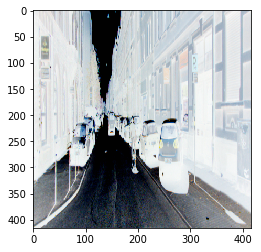

In [103]:
plt.imshow(generated_seq[0])
plt.show()